In [1]:
#importing necessary libraries 
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import yfinance as yf
from urllib.parse import quote
import seaborn as sns #library not from class
%matplotlib inline
from scipy.optimize import minimize
import mplcursors

In [2]:
#Load .env environment variables
from dotenv import load_dotenv
load_dotenv()


True

In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

In [4]:
# Set Alpaca API key and secret
APCA_API_KEY_ID = os.getenv("APCA_API_KEY")
APCA_API_SECRET_KEY = os.getenv("APCA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")

#ensuring api keys are correct 
#print(os.getenv("APCA_API_KEY_ID"))
#print(os.getenv("APCA_API_SECRET_KEY"))
#print(os.getenv("ALPACA_ENDPOINT_KEY"))

# Create the Alpaca API object
alpaca = tradeapi.REST(APCA_API_KEY_ID, APCA_API_SECRET_KEY, api_version="v2",base_url= ALPACA_ENDPOINT_KEY)

## Part 1 - Portfolio Optimization 


In [5]:
#initializing variables
initial_investment = 1000
print(f'The initial investment is: ${initial_investment}')

stock_tickers = ['AAPL', 'AMZN', 'MSFT'] 
ticker_string = ', '.join(stock_tickers)
print(f'The selected stocks are: {stock_tickers}')

start_date = '2020-11-08'  # Set your desired start date
print(f'The start date is: {start_date}')

end_date = '2023-11-08'  # Set your desired start date
print(f'The start date is: {start_date}')

num_sims = 500 
print(f'The number of monte carlo simulations is: {num_sims}')

num_years = 3

The initial investment is: $1000
The selected stocks are: ['AAPL', 'AMZN', 'MSFT']
The start date is: 2020-11-08
The start date is: 2020-11-08
The number of monte carlo simulations is: 500


### Import S&P500 Data From Alpacas and Display Closing Prices From Chosen Stocks

In [6]:
from urllib.parse import quote

# Importing SP500 
spy = ["SPY"]

# Define the list of stock tickers, excluding SP500 initially
tickersList = stock_tickers + ['SPY']

# Set timeframe to '1D'
timeframe = '1D'

# Convert start_date and end_date to ISO format with New York timezone
start_date = pd.Timestamp(start_date, tz='America/New_York').isoformat()
end_date = pd.Timestamp(end_date, tz='America/New_York').isoformat()

# Create an empty DataFrame to store the results for tickers
df_combined_tickers = pd.DataFrame()

# Make the request to Alpaca API for each ticker
for ticker in tickersList:
    # Convert the ticker to URL-encoded format
    ticker_encoded = quote(ticker)
    
    # Make the request to Alpaca API to get bars data
    df_ticker = alpaca.get_bars(ticker_encoded, timeframe, limit=None, start=start_date, end=end_date).df
    
    # Select only the 'close' column and assign the new column name with the ticker symbol for clarity purposes
    df_ticker = df_ticker['close'].rename(ticker)
    
    # Combine the results
    df_combined_tickers = pd.concat([df_combined_tickers, df_ticker], axis=1)
    
spyDF = df_combined_tickers['SPY']
df_combined_tickers.drop(columns='SPY',inplace=True)

# Display the results (closing prices for chosen tickers)
df_combined_tickers

,AAPL,AMZN,MSFT
2020-11-09 05:00:00+00:00,116.32,3143.74,218.39
2020-11-10 05:00:00+00:00,116.00,3035.02,211.01
2020-11-11 05:00:00+00:00,119.49,3137.39,216.55
2020-11-12 05:00:00+00:00,119.21,3110.28,215.44
2020-11-13 05:00:00+00:00,119.26,3128.81,216.51
...,...,...,...
2023-11-02 04:00:00+00:00,177.57,138.07,348.32
2023-11-03 04:00:00+00:00,176.65,138.60,352.80
2023-11-06 05:00:00+00:00,179.23,139.74,356.53
2023-11-07 05:00:00+00:00,181.82,142.71,360.53


### Calculate Daily Return, Mean, Standard Deviation, and Last Day Closing Prices for selected tickers and SP500

In [7]:
# Calculate daily returns for all ticker's closing prices
daily_returns_tickers = df_combined_tickers.pct_change()
daily_returns_tickers.dropna(inplace=True)

# Display daily returns for the tickers
print("\nDaily Returns for Chosen Stocks:")
print(daily_returns_tickers)

mean = {} 

# Iterate through each stock in the list of tickers
for stock in stock_tickers:
    # Check if the stock exists in the daily returns columns
    if stock in daily_returns_tickers.columns:
        mean[stock] = daily_returns_tickers.mean()[stock]  # Calculate mean for the stock and store in the dictionary
        print(f'{stock} mean: {mean[stock]}')  # Print the mean of daily returns for the stock


Daily Returns for Chosen Stocks:
                               AAPL      AMZN      MSFT
2020-11-10 05:00:00+00:00 -0.002751 -0.034583 -0.033793
2020-11-11 05:00:00+00:00  0.030086  0.033730  0.026255
2020-11-12 05:00:00+00:00 -0.002343 -0.008641 -0.005126
2020-11-13 05:00:00+00:00  0.000419  0.005958  0.004967
2020-11-16 05:00:00+00:00  0.008720  0.000719  0.003325
...                             ...       ...       ...
2023-11-02 04:00:00+00:00  0.020693  0.007810  0.006502
2023-11-03 04:00:00+00:00 -0.005181  0.003839  0.012862
2023-11-06 05:00:00+00:00  0.014605  0.008225  0.010573
2023-11-07 05:00:00+00:00  0.014451  0.021254  0.011219
2023-11-08 05:00:00+00:00  0.005885 -0.004415  0.007406

[754 rows x 3 columns]
AAPL mean: 0.0007580392192901268
AMZN mean: -0.0011414444220746664
MSFT mean: 0.0008290250824961204


In [8]:
# Calculate and display daily returns for 'SPY'
daily_returns_spy = spyDF.pct_change()
daily_returns_spy.dropna(inplace=True)

# Display daily returns for 'SPY'
print("\nDaily Returns for SPY:")
print(daily_returns_spy)

# Calculate and display mean of daily return for 'SPY'
mean_spy = daily_returns_spy.mean()
print("\nSPY mean:")
print(mean_spy)


Daily Returns for SPY:
2020-11-10 05:00:00+00:00   -0.001523
2020-11-11 05:00:00+00:00    0.007456
2020-11-12 05:00:00+00:00   -0.009475
2020-11-13 05:00:00+00:00    0.013471
2020-11-16 05:00:00+00:00    0.012510
                               ...   
2023-11-02 04:00:00+00:00    0.019164
2023-11-03 04:00:00+00:00    0.009123
2023-11-06 05:00:00+00:00    0.002300
2023-11-07 05:00:00+00:00    0.002846
2023-11-08 05:00:00+00:00    0.000732
Name: SPY, Length: 754, dtype: float64

SPY mean:
0.00033975975529095334


In [15]:
# Calculate and display standard deviation for each ticker
std_devs = {}
for stock in stock_tickers:
    if stock in daily_returns_tickers.columns:
        std_devs[stock] = daily_returns_tickers.std()[stock]
        print(f'{stock} standard deviation: {std_devs[stock]}')

AAPL standard deviation: 0.0177839401327225
AMZN standard deviation: 0.04183369731744983
MSFT standard deviation: 0.017581619238321928


In [16]:
# Calculate and display standard deviation for 'SPY'
std_dev_spy = daily_returns_spy.std()
print("\nStandard Deviation for SPY:")
print(std_dev_spy)


Standard Deviation for SPY:
0.011131185108019043


In [17]:
# Get the last day's closing prices for each ticker
last_day_closing_prices = df_combined_tickers.iloc[-1]

# Display the last day's closing prices
print("\nLast Day's Closing Prices:")
print(last_day_closing_prices)



Last Day's Closing Prices:
AAPL    182.89
AMZN    142.08
MSFT    363.20
Name: 2023-11-08 05:00:00+00:00, dtype: float64


In [18]:
# Get the last day's closing price for 'SPY'
spy_last_day_closing_price = spyDF.iloc[-1]
print("\nLast Day's Closing Price for SPY:")
print(spy_last_day_closing_price)


Last Day's Closing Price for SPY:
437.25


## Part 2 - Monte Carlo Simulations

In [20]:
# Calculate the total number of simulations based on the specified number of years and trading days per year
num_sims = (num_years * 252)

# Initialize DataFrames to store Monte Carlo simulation results
monte_carlo_results = pd.DataFrame()
monte_carlo_spy_results = pd.DataFrame()

# Create lists and variables to store optimization results and simulated data
optimal_weights_list = []
simulated_returns_list = []

# Create dictionaries and DataFrames to store simulated prices for individual stocks and SPY
simulated_prices_stocks = {stock: pd.DataFrame() for stock in stock_tickers}
simulated_prices_spy = pd.DataFrame()

# Define the negative Sharpe ratio function for optimization
def negative_sharpe_ratio(weights):
    weights_array = np.array(weights)
    portfolio_returns = np.sum(simulated_returns.mean() * weights_array) * 252
    portfolio_volatility = np.sqrt(np.dot(weights_array.T, np.dot(simulated_returns.cov() * 252, weights_array)))
    sharpe_ratio = portfolio_returns / portfolio_volatility
    return -sharpe_ratio

# Define the constraint function ensuring allocation sums to 1
def check_allocation_sum(weights):
    return np.sum(weights) - 1

simulated_prices_spy_list = [spy_last_day_closing_price] + [0] * (num_sims - 1)

# Monte Carlo simulation loop
for simulation_index in range(num_sims):
    # Simulate prices for each trading day
    simulated_prices_dict = {
        stock: [last_day_closing_prices[stock]] + [0] * (num_sims - 1) for stock in stock_tickers
        }
    
    for day_index in range(1, num_sims):
        for stock in stock_tickers:
        # Simulate stock prices using a normal distribution based on historical mean and standard deviation
            simulated_price = simulated_prices_dict[stock][day_index - 1] * (
                1 + np.random.normal(mean[stock], std_devs[stock])
            )
            simulated_prices_dict[stock][day_index] = simulated_price

        # Simulate SPY prices using a normal distribution based on historical mean and standard deviation
        simulated_spy_price = simulated_prices_spy_list[day_index - 1] * (
            1 + np.random.normal(mean_spy, std_dev_spy)
        )
        simulated_prices_spy_list[day_index] = simulated_spy_price

    # Store simulated prices in DataFrames
    for stock in stock_tickers:
        simulated_prices_stocks[stock][simulation_index] = pd.Series(simulated_prices_dict[stock])

    simulated_prices_df = pd.DataFrame(simulated_prices_dict)
    simulated_returns = simulated_prices_df.pct_change().dropna()
    simulated_returns_list.append(simulated_returns)

    # Define optimization constraints and boundaries
    constraints = [{'type': 'eq', 'fun': check_allocation_sum}]
    allocation_bounds = [(0, 1)] * len(stock_tickers)

    # Perform portfolio optimization using the scipy minimize function
    initial_guess = [1 / len(stock_tickers)] * len(stock_tickers)
    optimization_results = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=allocation_bounds, constraints=constraints)

    # Retrieve and store optimal weights
    optimal_weights = optimization_results.x
    optimal_weights_list.append(optimal_weights)

    # Calculate portfolio daily returns using the optimized weights
    portfolio_daily_returns = simulated_returns.dot(optimal_weights)

    # Calculate cumulative returns for the portfolio
    monte_carlo_results[simulation_index] = (1 + portfolio_daily_returns).cumprod()

    # Calculate cumulative returns for the SPY simulation
    monte_carlo_spy_results[simulation_index] = (1 + pd.Series(simulated_prices_spy_list).pct_change().dropna()).cumprod()

    print(optimal_weights)


[0.50012966 0.05313815 0.44673218]
[0.00000000e+00 1.66533454e-16 1.00000000e+00]
[9.57605295e-01 4.68375339e-17 4.23947051e-02]
[0.11782169 0.         0.88217831]
[2.03313242e-16 1.33749419e-02 9.86625058e-01]
[5.27739668e-01 5.22689897e-17 4.72260332e-01]
[2.81206099e-01 8.59094385e-18 7.18793902e-01]
[1.75581618e-01 4.73466752e-14 8.24418382e-01]
[0.23546599 0.00969573 0.75483827]
[2.44591195e-01 1.80763570e-15 7.55408805e-01]
[2.66243875e-01 3.85168932e-15 7.33756125e-01]
[0.16437807 0.         0.83562193]
[0.80284488 0.00183517 0.19531996]
[0.32375524 0.         0.67624476]
[0.81569855 0.         0.18430145]
[0.58754037 0.         0.41245963]
[0.61843438 0.         0.38156562]
[0.         0.48911399 0.51088601]
[0.68732154 0.         0.31267846]
[3.90653466e-01 7.53151881e-15 6.09346534e-01]
[2.22044605e-16 0.00000000e+00 1.00000000e+00]
[7.98427674e-02 2.67797937e-16 9.20157233e-01]
[0.19000212 0.00325929 0.8067386 ]
[1.00000000e+00 2.16493490e-15 2.77555756e-16]
[0.30380471 0.  

/var/folders/bk/8p802pg50f31n1clyfc4y7700000gn/T/ipykernel_44560/1332557318.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  simulated_prices_stocks[stock][simulation_index] = pd.Series(simulated_prices_dict[stock])
/var/folders/bk/8p802pg50f31n1clyfc4y7700000gn/T/ipykernel_44560/1332557318.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  monte_carlo_results[simulation_index] = (1 + portfolio_daily_returns).cumprod()
/var/folders/bk/8p802pg50f31n1clyfc4y7700000gn/T/ipykernel_44560/1332557318.py:78: PerformanceWarning: 

[0.40000972 0.         0.59999028]
[0.85240082 0.00092503 0.14667415]
[0.46453951 0.05930823 0.47615227]
[0.75146204 0.05267003 0.19586793]
[9.90874049e-15 0.00000000e+00 1.00000000e+00]
[3.64797552e-01 2.77013655e-16 6.35202448e-01]
[7.66293974e-01 2.00089511e-16 2.33706026e-01]
[0.87108208 0.         0.12891792]
[2.49506506e-01 5.99563801e-17 7.50493494e-01]
[1.96652478e-01 1.62031645e-15 8.03347522e-01]
[1.00000000e+00 0.00000000e+00 6.24500451e-15]
[0.32873502 0.         0.67126498]
[1.00000000e+00 0.00000000e+00 1.72084569e-15]
[1.00000000e+00 0.00000000e+00 9.32587341e-15]
[2.12233418e-01 1.52330405e-16 7.87766582e-01]
[7.22493278e-01 2.42861287e-17 2.77506722e-01]
[0.26899267 0.         0.73100733]
[0.17288557 0.08432307 0.74279136]
[5.55111512e-17 5.55111512e-17 1.00000000e+00]
[0.5953155  0.03591388 0.36877061]
[0.45040235 0.07095672 0.47864093]
[3.31998880e-01 3.52636757e-17 6.68001120e-01]
[5.55111512e-17 0.00000000e+00 1.00000000e+00]
[6.63254127e-01 1.26822331e-16 3.367458

###  Representing the Simulated Cumulative Returns of a portfolio over time for 500 Monte Carlo Simulations

Each column corresponds to a specific simulation, and each row represents the cumulative returns at a specific time point

In [21]:
monte_carlo_results

,0,1,2,3,4,5,6,7,8,9,...,746,747,748,749,750,751,752,753,754,755
1,1.027744,0.931902,1.006255,1.027642,1.001003,1.021881,1.008912,1.040064,1.002791,1.026958,...,1.005121,1.039333,0.987457,1.015266,1.001049,0.991237,1.007884,0.998259,0.975917,1.014283
2,1.034284,0.943989,1.005955,1.034053,0.996980,1.022711,1.021196,1.026908,1.009407,1.041089,...,1.036447,1.040550,0.995029,1.030507,0.998051,1.013707,0.993090,0.979741,0.967520,1.027975
3,1.021774,0.950159,1.030486,1.038423,0.993739,1.022009,1.011360,1.015009,1.010922,1.061827,...,1.031348,1.023633,1.010614,1.055206,1.005070,1.012009,1.005698,0.967092,0.973295,1.016561
4,1.020129,0.964695,1.030492,1.065497,0.995794,1.029703,1.008994,1.015778,1.021448,1.026199,...,1.009762,1.017877,1.016219,1.049951,1.009499,1.013560,1.005240,0.961517,0.969401,0.998999
5,1.032590,0.990566,1.050357,1.070905,0.979670,1.035980,1.016925,1.012873,0.997427,1.030335,...,1.038257,1.030136,1.020450,1.045863,0.998240,1.004139,0.998507,0.944108,0.954186,0.996038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2.153045,1.913061,2.641264,1.300675,1.068038,1.866433,3.329837,1.027473,2.444801,3.127767,...,1.424012,2.041983,2.152770,2.400610,1.803231,2.024317,2.182402,2.717617,1.942523,1.786072
752,2.135658,1.887962,2.628617,1.323796,1.073442,1.834190,3.394765,1.030376,2.458697,3.200486,...,1.378190,2.065366,2.166749,2.326788,1.802549,2.034332,2.186714,2.736665,1.922075,1.760027
753,2.146343,1.900205,2.632064,1.317270,1.061160,1.807957,3.414540,1.035901,2.447037,3.190236,...,1.351802,2.026151,2.172794,2.308669,1.832722,2.043828,2.197037,2.817336,1.874796,1.778489
754,2.134571,1.964001,2.652862,1.305438,1.066582,1.789419,3.397345,1.039940,2.506198,3.215390,...,1.344998,2.062421,2.160129,2.336053,1.815013,2.097723,2.199590,2.822487,1.880868,1.773003


In [33]:
#commenting out because the output is long (500 sims)
#mc_opt_weights

In [26]:
# Initialize lists to store individual DataFrames
monte_carlo_avg_optimized_list = []
mc_uniform_portfolio_daily_returns_list = []

# Monte Carlo Simulation Loop
for simulation_index in range(num_sims):
    # Simulate prices for each trading day
    simulated_prices_dict = {
        stock: [last_day_closing_prices[stock]] * num_sims for stock in stock_tickers
    }
    simulated_prices_spy_list = [spy_last_day_closing_price] * num_sims

    for day_index in range(1, num_sims):
        for stock in stock_tickers:
            # Simulate stock prices using a normal distribution based on historical mean and standard deviation
            simulated_price = simulated_prices_dict[stock][day_index - 1] * (
                1 + np.random.normal(mean[stock], std_devs[stock])
            )
            simulated_prices_dict[stock][day_index] = simulated_price

        # Simulate SPY prices using a normal distribution based on historical mean and standard deviation
        simulated_spy_price = simulated_prices_spy_list[day_index - 1] * (
            1 + np.random.normal(mean_spy, std_dev_spy)
        )
        simulated_prices_spy_list[day_index] = simulated_spy_price

    # Store simulated prices in DataFrames
    simulated_prices_df = pd.DataFrame(simulated_prices_dict)
    simulated_returns = simulated_prices_df.pct_change().dropna()

    # ... (rest of the code)

    # Append DataFrames to the lists
    monte_carlo_avg_optimized_list.append(monte_carlo_results)
    mc_uniform_portfolio_daily_returns_list.append(monte_carlo_spy_results)

# Concatenate DataFrames to create the final result
monte_carlo_avg_optimized = pd.concat(monte_carlo_avg_optimized_list, axis=1)
mc_uniform_portfolio_daily_returns = pd.concat(mc_uniform_portfolio_daily_returns_list, axis=1)


### Displaying the Average Weights and Standard Deviation of the Optimized Weights for each stock in the portfolio

In [27]:
# Calculate average weights and standard deviation
average_weights_optimized = np.mean(optimal_weights_list, axis=0)
std_dev_weights_optimized = np.std(optimal_weights_list, axis=0)

# Display results
for i in range(len(stock_tickers)):
    print(f"{stock_tickers[i]}: Average Weight = {average_weights_optimized[i]}, Standard Deviation = {std_dev_weights_optimized[i]}")


AAPL: Average Weight = 0.4718993687237662, Standard Deviation = 0.3011805533508047
AMZN: Average Weight = 0.022341341825291707, Standard Deviation = 0.06150447977957937
MSFT: Average Weight = 0.5057592894495222, Standard Deviation = 0.30054293447364755


In [28]:
monte_carlo_avg_optimized.dropna(inplace=True)
monte_carlo_avg_optimized

,0,1,2,3,4,5,6,7,8,9,...,746,747,748,749,750,751,752,753,754,755
1,1.000356,1.012234,1.007148,0.978561,1.014151,0.986254,1.030136,1.001032,0.995358,1.000491,...,0.989276,1.016960,0.998259,1.000692,0.987122,1.002763,1.004776,1.010562,0.987856,0.985089
2,1.013460,1.033903,0.991862,0.983507,0.998604,0.971406,1.046825,1.000897,0.985977,0.990368,...,0.995505,1.018244,1.013269,0.976631,0.967546,1.007511,1.010366,0.984622,1.008331,1.004564
3,1.014489,1.026415,0.988239,0.982899,1.004773,0.974263,1.057248,1.026087,0.990155,0.979346,...,1.001822,1.013439,0.993553,0.998629,0.983878,1.012511,1.027569,0.970483,0.986072,0.995882
4,1.004884,1.013350,0.971133,0.990603,1.026044,0.955221,1.049489,1.025517,0.948499,0.975421,...,1.036525,0.991357,0.970838,0.992154,0.974750,1.020405,1.014222,0.947831,1.006424,1.026140
5,1.004616,1.006254,0.982680,0.998979,1.010930,0.953134,1.052492,1.009602,0.956096,0.976202,...,1.045056,0.999961,0.966023,0.995528,0.970730,1.012138,1.018294,0.954944,0.998163,1.033018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,1.333072,3.116388,2.247863,3.196737,3.064034,2.605632,3.041527,2.333767,1.855400,2.324723,...,1.518548,1.471622,1.466718,1.217917,3.274822,2.780761,1.869917,1.161408,1.938356,2.518586
752,1.356776,3.097509,2.246416,3.271503,3.129884,2.596600,3.063819,2.325333,1.920975,2.310686,...,1.565798,1.484349,1.491360,1.222667,3.270907,2.707907,1.885936,1.163149,1.919639,2.489804
753,1.349923,3.171339,2.243801,3.277008,3.130490,2.584269,3.135501,2.379446,1.855710,2.331135,...,1.557498,1.468428,1.484843,1.211362,3.236427,2.718711,1.869706,1.172853,1.931815,2.485964
754,1.327906,3.127984,2.220652,3.243889,3.188918,2.533682,3.179269,2.371502,1.872422,2.361570,...,1.600007,1.518999,1.467817,1.211766,3.286173,2.672909,1.844899,1.183809,1.923081,2.498797


### Bar Chart of Average Weights of Chosen Stocks

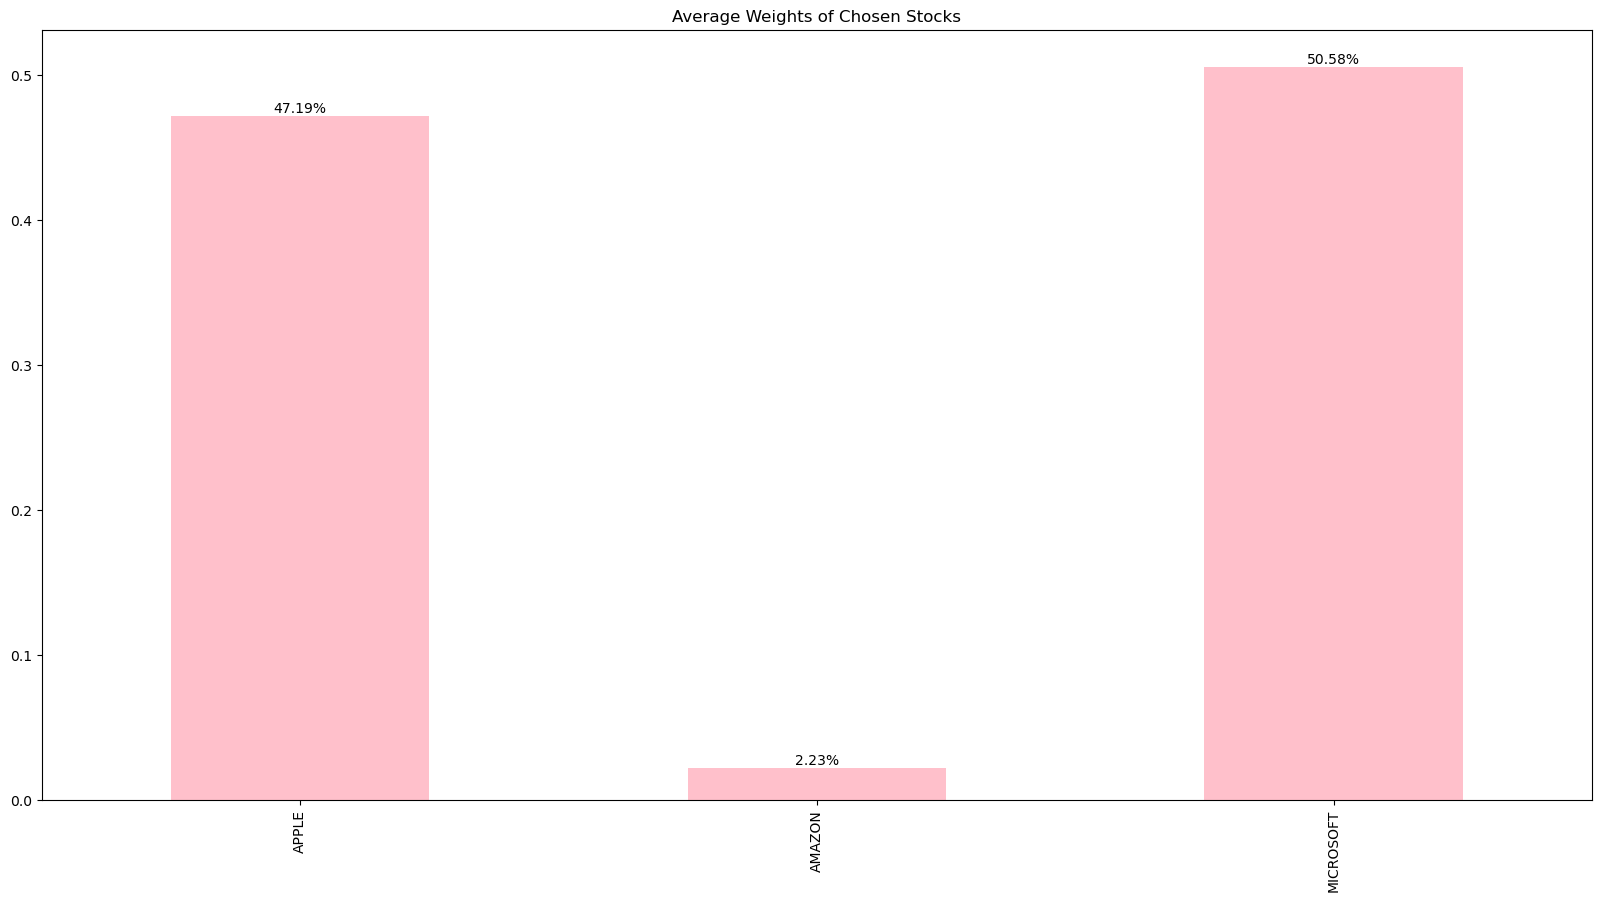

In [29]:
# Plotting the average weights
average_weights_series = pd.Series(average_weights_optimized, index=stock_tickers)
ax = average_weights_series.plot.bar(figsize=(20, 10), color='pink', title='Average Weights of Chosen Stocks')

# Adding hover information to the plot
for i, val in enumerate(average_weights_optimized):
    plt.text(i, val, f'{val:.2%}', ha='center', va='bottom')

# Adding custom tick labels
plt.xticks(range(len(stock_tickers)), ['APPLE', 'AMAZON', 'MICROSOFT'])

# Adding exact weight information using mplcursors
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f"Weight: {sel.artist.get_height():.2%}"))

# Show the plot
plt.show()

In [30]:
monte_carlo_avg_optimized.iloc[-1]

0      1.317699
1      3.122409
2      2.249689
3      3.289592
4      3.205203
         ...   
751    2.716604
752    1.827486
753    1.183218
754    1.973231
755    2.468312
Name: 755, Length: 571536, dtype: float64